In [1]:
%matplotlib inline

import os
import sys
import glob
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install xgboost
import xgboost as xgb
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from scipy.stats import binned_statistic

# set style
sns.set_style('white')
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=300

     |████████████████████████████████| 109.7 MB 12.0 MB/s eta 0:00:01    |██████████████████▍             | 63.2 MB 12.1 MB/s eta 0:00:04     |████████████████████████▍       | 83.6 MB 12.4 MB/s eta 0:00:03     |███████████████████████████████▍| 107.7 MB 12.0 MB/s eta 0:00:01


In [2]:
# pre-processing steps to add to merge_pp()
## TODO: main() into nice py script
dfp = '/home/jovyan/work/ngr4/data/ed_data/final200427/final_4_27'
pdfp = '/home/jovyan/work/ngr4/data/processed/'
pfp = '/home/jovyan/work/ngr4/results/'


In [3]:
models = ['curb65redo','qSOFAredo','qCSIredo','CSIredo','cci']
methods = ['LR','LR','LR','XGB','LR']

print('\nResults')
print('---------------------------')
print('\tAU-ROC\tAccuracy\tSensitivity\tSpecificity')

for model_name,method in zip(models,methods):
        
    mets = pd.read_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)))
    ave = mets.mean(axis=0)
    lower = mets.quantile(axis=0,q=0.025)
    upper = mets.quantile(axis=0,q=0.975)

    print('{}\t{:.2f} ({:.2f},{:.2f})\t{:.2f} ({:.2f},{:.2f})\t{:.2f} ({:.2f},{:.2f})\t{:.2f} ({:.2f},{:.2f})'.format(
        model_name,
        ave['au-roc'],lower['au-roc'],upper['au-roc'],
        ave['accuracy'],lower['accuracy'],upper['accuracy'],
        ave['sensitivity'],lower['sensitivity'],upper['sensitivity'],
        ave['specificity'],lower['specificity'],upper['specificity']))


print('\nResults continued')
print('---------------------------')
print('\tAU-PRC\tBrier score\tF1\tAverage Precision')

for model_name,method in zip(models,methods):
        
    mets = pd.read_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)))
    ave = mets.mean(axis=0)
    lower = mets.quantile(axis=0,q=0.025)
    upper = mets.quantile(axis=0,q=0.975)

    print('{}\t{:.2f} ({:.2f},{:.2f})\t{:.2f} ({:.2f},{:.2f})\t{:.2f} ({:.2f},{:.2f})\t{:.2f} ({:.2f},{:.2f})'.format(
        model_name,
        ave['au-prc'],lower['au-prc'],upper['au-prc'],
        ave['brier'],lower['brier'],upper['brier'],
        ave['f1'],lower['f1'],upper['f1'],
        ave['ave_precision'],lower['ave_precision'],upper['ave_precision']))



Results
---------------------------
	AU-ROC	Accuracy	Sensitivity	Specificity
curb65redo	0.66 (0.58,0.78)	0.79 (0.56,0.94)	0.67 (0.29,1.00)	0.62 (0.27,0.93)
qSOFAredo	0.76 (0.69,0.86)	0.88 (0.82,0.95)	0.79 (0.62,1.00)	0.70 (0.60,0.80)
qCSIredo	0.90 (0.85,0.96)	0.84 (0.72,0.94)	0.90 (0.70,1.00)	0.79 (0.59,0.94)
CSIredo	0.91 (0.86,0.97)	0.83 (0.70,0.94)	0.94 (0.77,1.00)	0.82 (0.67,0.95)
cci	0.70 (0.62,0.80)	0.71 (0.40,0.86)	0.73 (0.47,1.00)	0.67 (0.33,0.88)

Results continued
---------------------------
	AU-PRC	Brier score	F1	Average Precision
curb65redo	0.26 (0.09,0.44)	0.10 (0.06,0.15)	0.20 (0.00,0.36)	0.20 (0.10,0.33)
qSOFAredo	0.35 (0.09,0.62)	0.09 (0.05,0.14)	0.21 (0.00,0.46)	0.26 (0.13,0.42)
qCSIredo	0.54 (0.27,0.76)	0.07 (0.04,0.11)	0.49 (0.30,0.67)	0.52 (0.30,0.72)
CSIredo	0.56 (0.25,0.80)	0.25 (0.25,0.28)	0.51 (0.29,0.70)	0.58 (0.31,0.81)
cci	0.20 (0.09,0.36)	0.10 (0.06,0.15)	0.30 (0.15,0.43)	0.22 (0.11,0.36)


# ROC/PRC

## Methods

Plotting median value

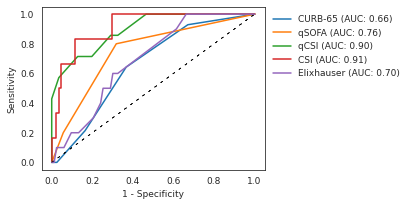

In [13]:
models = ['curb65redo','qSOFAredo','qCSIredo','CSIredo','cci']
methods = ['LR','LR','LR','XGB','LR']
colors = {v:sns.color_palette()[i] for i,v in enumerate(models)}
labels = {k:v for k,v in list(zip(models, ['CURB-65','qSOFA','qCSI','CSI','Elixhauser']))}

fig,ax=plt.subplots(1,1,figsize=(4,3))
for model_name,method in zip(models,methods):
    
    color_model = colors[model_name]
    
    mets = pd.read_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)))
    roc = pd.read_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)))
    pr = pd.read_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)))
    
    # get median iteration
    mets.sort_values(by='au-roc', inplace=True)
    median_idx = mets[mets['au-roc'] > mets['au-roc'].median()].index[0]
    pr = pr.loc[pr['iter']==median_idx,:]
    roc = roc.loc[roc['iter']==median_idx,:]
        
    p =sns.lineplot(x='fpr',
                    y='tpr',
                    data=roc,
                 estimator=None,
                 ci=None,
                 color=color_model,
                 label='{} (AUC: {:.2f})'.format(labels[model_name],mets['au-roc'].mean()),
                 ax=ax)
    ax.plot([0,1],[0,1],'k--',lw=0.5,dashes=(5, 10))
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')
    ax.legend(bbox_to_anchor=(1,1))
    
fig.savefig(os.path.join(pfp,'roc.png'),bbox_inches='tight',dpi=300)

In [ ]:
# different median selected
models = ['curb65redo','qSOFAredo','qCSIredo','CSIredo','cci']
methods = ['LR','LR','LR','XGB','LR']
colors = {v:sns.color_palette()[i] for i,v in enumerate(models)}

fig,ax=plt.subplots(1,2,figsize=(12,3))
for model_name,method in zip(models,methods):
    
    color_model = colors[model_name]
    
    mets = pd.read_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)))
    roc = pd.read_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)))
    pr = pd.read_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)))
    
    # get median iteration
    mets.sort_values(by='au-roc', inplace=True)
    median_idx = mets[mets['au-roc'] < mets['au-roc'].median()].index[-1]
    pr = pr.loc[pr['iter']==median_idx,:]
    roc = roc.loc[roc['iter']==median_idx,:]
        
    p =sns.lineplot(x='fpr',
                    y='tpr',
                    data=roc,
                 estimator=None,
                 ci=None,
                 color=color_model,
                 label='{} (AUC: {:.2f})'.format(model_name,mets['au-roc'].mean()),
                 ax=ax[0])
    ax[0].plot([0,1],[0,1],'k--',lw=0.5,dashes=(5, 10))
    ax[0].set_xlabel('1 - Specificity')
    ax[0].set_ylabel('Sensitivity')
    ax[0].legend(bbox_to_anchor=(1,1))
    
    sns.lineplot(x='recall',
                 y='precision',
                 data=pr,
                 estimator=None,
                 color=color_model,
                 label='{} (AUC: {:.2f})'.format(model_name,mets['au-prc'].mean()),ax=ax[1])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].legend(bbox_to_anchor=(1,1))
fig.tight_layout()

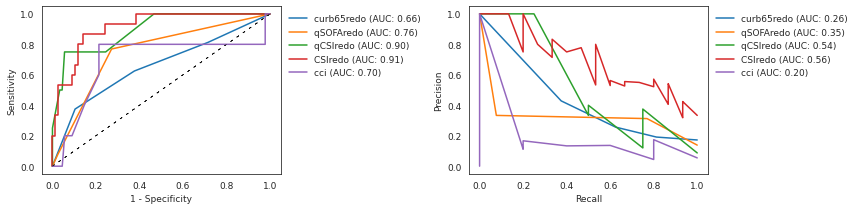

In [42]:
# different median selected
models = ['curb65redo','qSOFAredo','qCSIredo','CSIredo','cci']
methods = ['LR','LR','LR','XGB','LR']
colors = {v:sns.color_palette()[i] for i,v in enumerate(models)}

fig,ax=plt.subplots(1,2,figsize=(12,3))
for model_name,method in zip(models,methods):
    
    color_model = colors[model_name]
    
    mets = pd.read_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)))
    roc = pd.read_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)))
    pr = pd.read_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)))
    
    # get median iteration
    mets.sort_values(by='au-roc', inplace=True)
    median_idx = mets[mets['au-roc'] < mets['au-roc'].median()].index[-1]
    pr = pr.loc[pr['iter']==median_idx,:]
    roc = roc.loc[roc['iter']==median_idx,:]
        
    p =sns.lineplot(x='fpr',
                    y='tpr',
                    data=roc,
                 estimator=None,
                 ci=None,
                 color=color_model,
                 label='{} (AUC: {:.2f})'.format(model_name,mets['au-roc'].mean()),
                 ax=ax[0])
    ax[0].plot([0,1],[0,1],'k--',lw=0.5,dashes=(5, 10))
    ax[0].set_xlabel('1 - Specificity')
    ax[0].set_ylabel('Sensitivity')
    ax[0].legend(bbox_to_anchor=(1,1))
    
    sns.lineplot(x='recall',
                 y='precision',
                 data=pr,
                 estimator=None,
                 color=color_model,
                 label='{} (AUC: {:.2f})'.format(model_name,mets['au-prc'].mean()),ax=ax[1])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].legend(bbox_to_anchor=(1,1))
fig.tight_layout()

# ROC/PRC

## Methods

Applying kalman or 1d-signal processing filtering to the replicate data of curves to obtain smooth, representative ROCs over the space 


In [9]:
model_name = 'CSIredo'
method='XGB'
mets = pd.read_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)))
roc = pd.read_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)))
pr = pd.read_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)))
x = roc['fpr']
y = roc['tpr']

(0.0, 1.0)

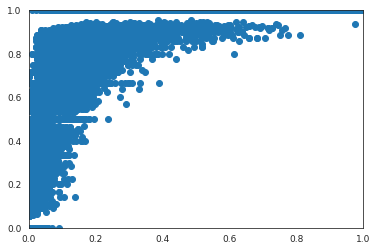

In [18]:
plt.scatter(x,y)
plt.xlim([0,1])
plt.ylim([0,1])

(0.0, 1.0)

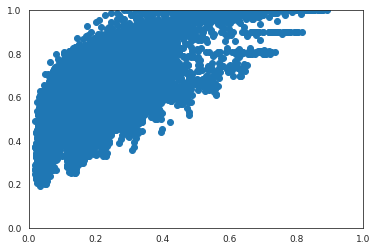

In [19]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

 
yMA = movingaverage(y,10)
xMA = movingaverage(x,10)
plt.scatter(xMA,yMA)
plt.xlim([0,1])
plt.ylim([0,1])
#print yMA

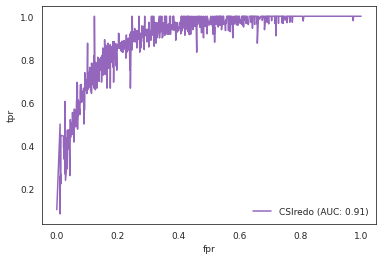

In [21]:
p = sns.lineplot(x=x,
                 y=y,
             estimator='mean',
             ci=None,
             color=color_model,
             label='{} (AUC: {:.2f})'.format(model_name,mets['au-roc'].mean()))
p.legend()

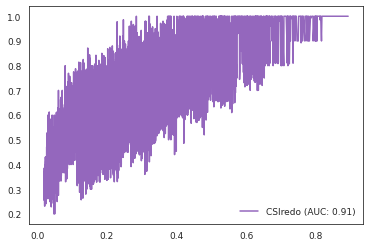

In [20]:
p = sns.lineplot(x=xMA,
                 y=yMA,
             estimator='mean',
             ci=None,
             color=color_model,
             label='{} (AUC: {:.2f})'.format(model_name,mets['au-roc'].mean()))
p.legend()

In [ ]:
# REF: Andrew D. Straw, https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html

# intial parameters
n_iter = 50
sz = (n_iter,) # size of array
x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

plt.figure()
plt.plot(z,'k+',label='noisy measurements')
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01])
plt.show()

# dev

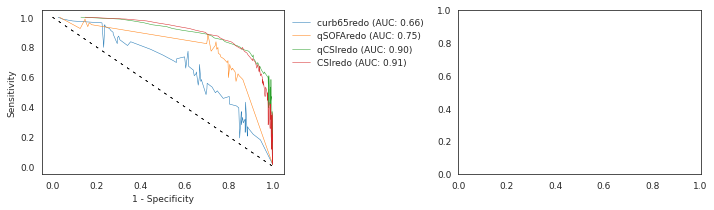

In [75]:
models = ['curb65redo','qSOFAredo','qCSIredo','CSIredo']
methods = ['LR','LR','LR','XGB']
colors = {v:sns.color_palette()[i] for i,v in enumerate(models)}

fig,ax=plt.subplots(1,2,figsize=(10,3))
for model_name,method in zip(models,methods):
    
    color_model = colors[model_name]
    
    mets = pd.read_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)))
    roc = pd.read_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)))
    pr = pd.read_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)))
    
    # summarize table
        
#     fprprime = np.linspace(roc['fpr'].min(), roc['fpr'].max(), 50) 
#     spline = make_interp_spline(roc['fpr'].to_numpy(), roc['tpr'].to_numpy(), k=3)  
#     tprprime = spl(fprprime)

    x,y,_ = binned_statistic(roc['fpr'],roc['tpr'],statistic='mean', bins=np.linspace(0,1,80))
    
    p =sns.lineplot(x=x,
                    y=1-y[:-1],
                 estimator=None,
                 ci=None,
                 color=color_model,
                 label='{} (AUC: {:.2f})'.format(model_name,mets['au-roc'].mean()),
                 ax=ax[0],
                 linewidth=0.5)
    ax[0].plot([0,1],[1,0],'k--',lw=0.5,dashes=(5, 10))
    ax[0].set_xlabel('1 - Specificity')
    ax[0].set_ylabel('Sensitivity')
    ax[0].legend(bbox_to_anchor=(1,1))
    
fig.tight_layout()

# sns.lineplot(recall,precision,
#              estimator=None,
#              color=color_model,
#              label='{} (AUC: {:.2f})'.format(model_name,auprc),ax=ax[1])
# ax[1].set_xlabel('Recall')
# ax[1].set_ylabel('Precision')
# ax[1].legend(bbox_to_anchor=(1,1))

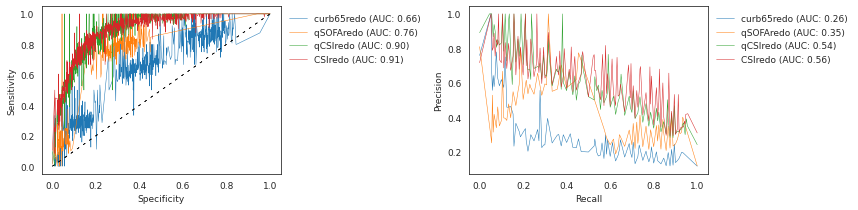

In [105]:
models = ['curb65redo','qSOFAredo','qCSIredo','CSIredo']
methods = ['LR','LR','LR','XGB']
colors = {v:sns.color_palette()[i] for i,v in enumerate(models)}

fig,ax=plt.subplots(1,2,figsize=(12,3))
for model_name,method in zip(models,methods):
    
    color_model = colors[model_name]
    
    mets = pd.read_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)))
    roc = pd.read_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)))
    pr = pd.read_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)))
    
    # summarize table
        
#     fprprime = np.linspace(roc['fpr'].min(), roc['fpr'].max(), 50) 
#     spline = make_interp_spline(roc['fpr'].to_numpy(), roc['tpr'].to_numpy(), k=3)  
#     tprprime = spl(fprprime)

    
    p =sns.lineplot(x='fpr',
                    y='tpr',
                    data=roc,
                 estimator='mean',
                 ci=None,
                 color=color_model,
                 label='{} (AUC: {:.2f})'.format(model_name,mets['au-roc'].mean()),
                 ax=ax[0],
                 linewidth=0.5)
    ax[0].plot([0,1],[0,1],'k--',lw=0.5,dashes=(5, 10))
    ax[0].set_xlabel('Specificity')
    ax[0].set_ylabel('Sensitivity')
    ax[0].legend(bbox_to_anchor=(1,1))
    

    sns.lineplot(x='recall',y='precision',
                 data=pr,
                 estimator='mean',
                 ci=None,
                 color=color_model,
                 label='{} (AUC: {:.2f})'.format(model_name,mets['au-prc'].mean()),
                 linewidth=0.5,
                 ax=ax[1])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].legend(bbox_to_anchor=(1,1))
fig.tight_layout()

# OLD

In [2]:
def qcsi(df):
    """Calcualate quick-CSI and return score for training.
    Arguments:
        df (pd.DataFrame): can be within cv-fold
    """
    # impute
    temp = SimpleImputer(verbose=1, strategy='median').fit_transform(df)
    ## convert back to pandas
    df = pd.DataFrame(temp, columns=df.columns, dtype='float64')
    temp = pd.DataFrame()
    temp['last_o2_flow'] = pd.cut(df['last_o2_flow'],
                                 bins=[-np.inf,2,4,np.inf],
                                 labels=['no_nc','2-4','gt4'])
    temp['min_SPO2'] = pd.cut(df['min_SPO2'],
                                 bins=[-np.inf,88,92,np.inf],
                                 labels=['lt88','88-92','gt92'])
    temp['last_RR'] = pd.cut(df['last_RR'],
                                 bins=[-np.inf,22,28,np.inf],
                                 labels=['lt22','22-28','gt28'])
    # round(2*OR) - 2
    temp['qcsi'] = 0
    temp.loc[temp['last_o2_flow']=='2-4','qcsi'] = 4 + temp.loc[temp['last_o2_flow']=='2-4','qcsi']
    temp.loc[temp['last_o2_flow']=='gt4','qcsi'] = 5 + temp.loc[temp['last_o2_flow']=='gt4','qcsi']
    temp.loc[temp['min_SPO2']=='lt88','qcsi'] = 5 + temp.loc[temp['min_SPO2']=='lt88','qcsi']
    temp.loc[temp['min_SPO2']=='88-92','qcsi'] = 2 + temp.loc[temp['min_SPO2']=='88-92','qcsi']
    temp.loc[temp['last_RR']=='22-28','qcsi'] = 1 + temp.loc[temp['last_RR']=='22-28','qcsi']
    temp.loc[temp['last_RR']=='gt28','qcsi'] = 2 + temp.loc[temp['last_RR']=='gt28','qcsi']
    
    return temp['qcsi'] 

def pp_X(df):
    min_feat = ['min_SPO2','last_o2_flow','last_RR','bun',
                'ast','age','last_SBP',
                'glucose',
                'WBC','PROCAL','FERRITIN','CRP',
                'creatinine','chloride','alt']
    if False:
        df.loc[df['ox_status240_ROOM_AIR']==1,'last_o2_flow'] = 0 
    df = df.loc[:,min_feat]
    return df

In [8]:
# run for all models, test performance
models = ['CSIredo','qCSIredo']
methods = ['XGB','LR']

X_test = pd.read_csv(os.path.join(pdfp,'X_test.csv'),index_col=0)
y_test = pd.read_csv(os.path.join(pdfp,'y_test.csv'),index_col=0)

for model_name,method in zip(models,methods):
    model_pkl = glob.glob(os.path.join(pdfp,'{}_{}iter*.pkl'.format(model_name,method)))[0]

    # load model
    model = pickle.load(open(model_pkl, "rb"))

    # evaluate
    if method=='XGB':
        dtest = xgb.DMatrix(pp_X(X_test), label=y_test)
        ptest = model.predict(dtest, ntree_limit=model.best_iteration)
    elif method=='LR':
        ptest = model.predict_proba(qcsi(X_test).to_numpy().reshape(-1,1))[:,1]

    # metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ptest)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (ptest>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_test, ptest)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_test,ptest)
    ap = metrics.average_precision_score(y_test,ptest)
    bs = metrics.brier_score_loss(y_test,ptest)
    f1 = metrics.f1_score(y_test,optimal_pred)
    acc = metrics.accuracy_score(y_test,optimal_pred)

    # results
    print('\n{} {} results'.format(model_name, method))
    print('---------------------------------')
    print('Accuracy:          {:.4f}%'.format(acc))
    print('Sensitivity:       {:.4f}'.format(tpr[optimal_idx]))
    print('Specificity:       {:.4f}'.format(1-fpr[optimal_idx]))
    print('AU-ROC:            {:.4f}'.format(auroc))
    print('AU-PRC:            {:.4f}'.format(auprc))
    print('Average-precision: {:.4f}'.format(ap))
    print('Brier score:       {:.4f}'.format(bs))
    print('F1-score:          {:.4f}'.format(f1))





CSIredo XGB results
---------------------------------
Accuracy:          0.8083%
Sensitivity:       0.6970
Specificity:       0.8309
AU-ROC:            0.7605
AU-PRC:            0.3773
Average-precision: 0.3894
Brier score:       0.2509
F1-score:          0.4889

qCSIredo LR results
---------------------------------
Accuracy:          0.8042%
Sensitivity:       0.8182
Specificity:       0.7295
AU-ROC:            0.8195
AU-PRC:            0.5461
Average-precision: 0.4959
Brier score:       0.0909
F1-score:          0.4835



CSIoldbst XGB results
---------------------------------
Accuracy:          0.9677%
Sensitivity:       1.0000
Specificity:       0.9775
AU-ROC:            0.9916
AU-PRC:            0.8354
Average-precision: 0.8542
Brier score:       0.2641
F1-score:          0.6667

curb65redo LR results
---------------------------------
Accuracy:          0.9785%
Sensitivity:       1.0000
Specificity:       0.9011
AU-ROC:            0.9505
AU-PRC:            0.5909
Average-precision: 0.1818
Brier score:       0.0323
F1-score:          0.0000

qSOFAredo LR results
---------------------------------
Accuracy:          0.9570%
Sensitivity:       1.0000
Specificity:       0.7528
AU-ROC:            0.9270
AU-PRC:            0.5385
Average-precision: 0.3269
Brier score:       0.0401
F1-score:          0.5000

qCSIredo LR results
---------------------------------
Accuracy:          0.9468%
Sensitivity:       1.0000
Specificity:       0.9000
AU-ROC:            0.9750
AU-PRC:            0.6962
Average-precision

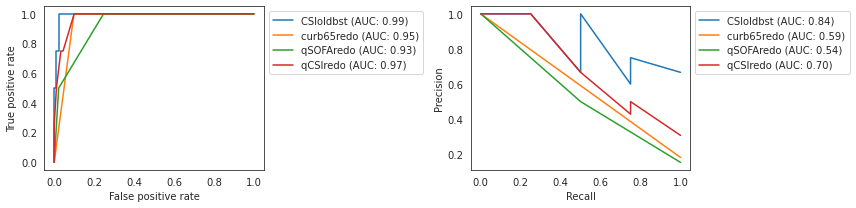

In [54]:
# run for all models, overplotting
models = ['CSIoldbst','curb65redo','qSOFAredo','qCSIredo']
methods = ['XGB','LR','LR','LR']
colors = {v:sns.color_palette()[i] for i,v in enumerate(models)}

fig,ax=plt.subplots(1,2,figsize=(12,3))
for model_name,method in zip(models,methods):

    color_model = colors[model_name]
    
    X_test = pd.read_csv(os.path.join(pdfp,'X_test.csv'),index_col=0)
    y_test = pd.read_csv(os.path.join(pdfp,'y_test.csv'),index_col=0)
    model_pkl = glob.glob(os.path.join(pdfp,'{}_{}iter*.pkl'.format(model_name,method)))[0]
    y_val = pd.read_csv(glob.glob(os.path.join(pdfp,'{}_{}iter*_yval.csv'.format(model_name,method)))[0])
    X_val = pd.read_csv(glob.glob(os.path.join(pdfp,'{}_{}iter*_Xval.csv'.format(model_name,method)))[0])

    # load model
    model = pickle.load(open(model_pkl, "rb"))

    # evaluate
    if method=='XGB':
        dval = xgb.DMatrix(X_val, label=y_val)
        pval = model.predict(dval, ntree_limit=model.best_iteration)
    elif method=='LR':
        pval = model.predict_proba(X_val.to_numpy().reshape(-1,1))[:,1]

    # metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pval)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (pval>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_val, pval)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_val,pval)
    ap = metrics.average_precision_score(y_val,pval)
    bs = metrics.brier_score_loss(y_val,pval)
    f1 = metrics.f1_score(y_val,optimal_pred)
    acc = metrics.accuracy_score(y_val,optimal_pred)

    # results
    print('\n{} {} results'.format(model_name, method))
    print('---------------------------------')
    print('Accuracy:          {:.4f}%'.format(acc))
    print('Sensitivity:       {:.4f}'.format(tpr[optimal_idx]))
    print('Specificity:       {:.4f}'.format(1-fpr[optimal_idx]))
    print('AU-ROC:            {:.4f}'.format(auroc))
    print('AU-PRC:            {:.4f}'.format(auprc))
    print('Average-precision: {:.4f}'.format(ap))
    print('Brier score:       {:.4f}'.format(bs))
    print('F1-score:          {:.4f}'.format(f1))





In [6]:
# load model
model = pickle.load(open(model_pkl, "rb"))

# evaluate
if method=='XGB':
    dval = xgb.DMatrix(pp_X(X_val), label=y_val)
    pval = model.predict(dval, ntree_limit=model.best_iteration)
elif method=='LR':
    pval = model.predict_proba(qcsi(X_val).to_numpy().reshape(-1,1))[:,1]
    
# metrics
fpr, tpr, thresholds = metrics.roc_curve(y_val, pval)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (pval>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_val, pval)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_val,pval)
ap = metrics.average_precision_score(y_val,pval)
bs = metrics.brier_score_loss(y_val,pval)
f1 = metrics.f1_score(y_val,optimal_pred)
acc = metrics.accuracy_score(y_val,optimal_pred)

# results
print('{} {} results'.format(model_name, method))
print('---------------------------------')
print('Accuracy:          {:.4f}%'.format(acc))
print('Sensitivity:       {:.4f}'.format(tpr[optimal_idx]))
print('Specificity:       {:.4f}'.format(1-fpr[optimal_idx]))
print('AU-ROC:            {:.4f}'.format(auroc))
print('AU-PRC:            {:.4f}'.format(auprc))
print('Average-precision: {:.4f}'.format(ap))
print('Brier score:       {:.4f}'.format(bs))
print('F1-score:          {:.4f}'.format(f1))


CSIoldbst XGB results
---------------------------------
Accuracy:          0.9677%
Sensitivity:       1.0000
Specificity:       0.9775
AU-ROC:            0.9916
AU-PRC:            0.8354
Average-precision: 0.8542
Brier score:       0.2641
F1-score:          0.6667


Text(0, 0.5, 'Precision')

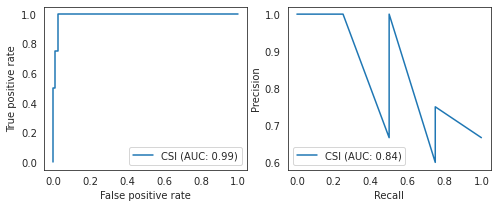

In [20]:

fig,ax=plt.subplots(1,2,figsize=(8,3))
sns.lineplot(fpr,tpr,
             estimator=None,
             label='CSI (AUC: {:.2f})'.format(auroc),ax=ax[0])
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')

sns.lineplot(recall,precision,
             estimator=None,
             label='CSI (AUC: {:.2f})'.format(auprc),ax=ax[1])
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
